In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('C:/Users/keert/OneDrive/Desktop/Mini Project/resampled_lob_minALL.csv')

data.head()

,Datetime,Min Ask Price,Max Bid Price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity
0,2025-01-02 00:00:00,271.841538,260.186154,22881.0,16799.0,3,5
1,2025-01-02 00:01:00,262.803138,258.206847,24821.0,12978.0,2,3
2,2025-01-02 00:02:00,267.596615,262.929478,33966.0,11786.0,2,3
3,2025-01-02 00:03:00,267.066274,262.751105,30396.0,15613.0,3,2
4,2025-01-02 00:04:00,268.358289,263.077540,28408.0,16458.0,3,4


In [2]:
# Feature engineering: Price differentials and quantities ratios
data['price_diff'] = data['Min Ask Price'] - data['Max Bid Price']
data['quantity_ratio'] = data['Total Bid Quantity'] / (data['Total Ask Quantity'] + 1) 

# Additional statistical features: rolling averages
data['rolling_avg_bid'] = data['Max Bid Price'].rolling(window=5).mean()
data['rolling_avg_ask'] = data['Min Ask Price'].rolling(window=5).mean()


In [3]:
# Compute mid-price and future mid-price
data['mid_price'] = (data['Min Ask Price'] + data['Max Bid Price']) / 2
data['future_mid_price'] = data['mid_price'].shift(-1)

# Define target: 1 if the mid-price will increase, 0 otherwise
data['target'] = (data['future_mid_price'] > data['mid_price']).astype(int)
data.dropna(inplace=True)  # Drop the last row which now includes NaN

In [4]:
# Normalize features
scaler = MinMaxScaler()
features = ['price_diff', 'quantity_ratio', 'rolling_avg_bid', 'rolling_avg_ask']
data_scaled = scaler.fit_transform(data[features])
data_scaled = pd.DataFrame(data_scaled, columns=features)

In [6]:
import numpy as np

data[features] = scaler.fit_transform(data[features])

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define target and features
X = data[features]
y = data['mid_price']  # Predicting the mid_price

# Creating sequences
time_steps = 10  # Number of time steps you want to look back
X_seq, y_seq = create_sequences(X, y, time_steps)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=25, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting the next mid_price
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

C:\Users\keert\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=False)


Epoch 1/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - loss: 84496.7656 - mae: 285.2091 - val_loss: 17139.6953 - val_mae: 130.1425
Epoch 2/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - loss: 67087.4297 - mae: 252.7571 - val_loss: 9873.9570 - val_mae: 98.3428
Epoch 3/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 52103.1133 - mae: 221.0730 - val_loss: 4823.2588 - val_mae: 67.9751
Epoch 4/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 39692.4453 - mae: 190.8645 - val_loss: 1745.3628 - val_mae: 39.2895
Epoch 5/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 29568.4121 - mae: 162.1325 - val_loss: 362.9353 - val_mae: 14.8272
Epoch 6/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 21669.4453 - mae: 136.5912 - val_loss: 326.5273 - val_mae: 15.2772
Epoch 7/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 15850.8877 - mae: 115.5325 - val_loss: 1176.0518 - val_mae: 31.5965
Epoch 8/30
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 11702.2783 -

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1299.7062 - mae: 34.2073
Test MSE: 1332.7901611328125, Test MAE: 34.500064849853516


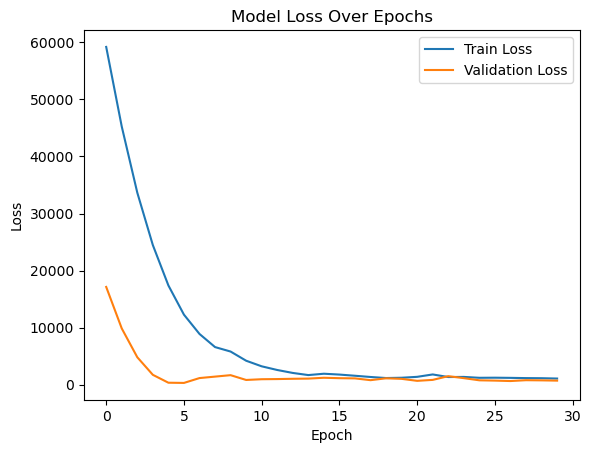

In [9]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}, Test MAE: {mae}')

# Optionally plot history for loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


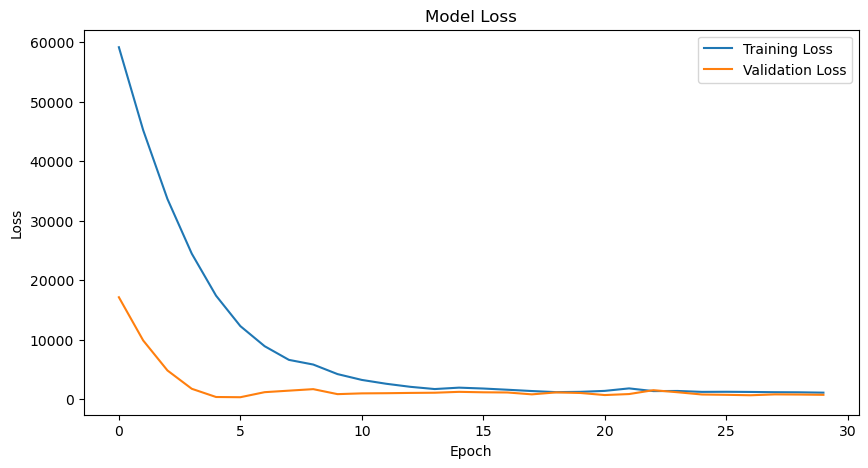

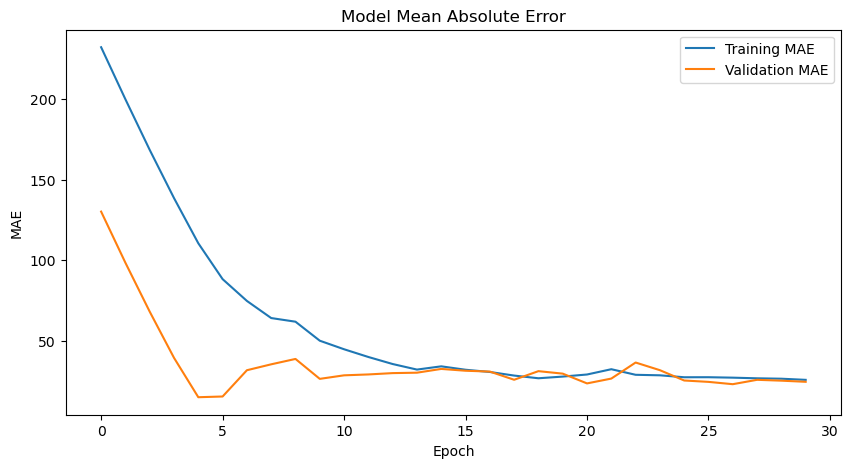

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation mean absolute error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


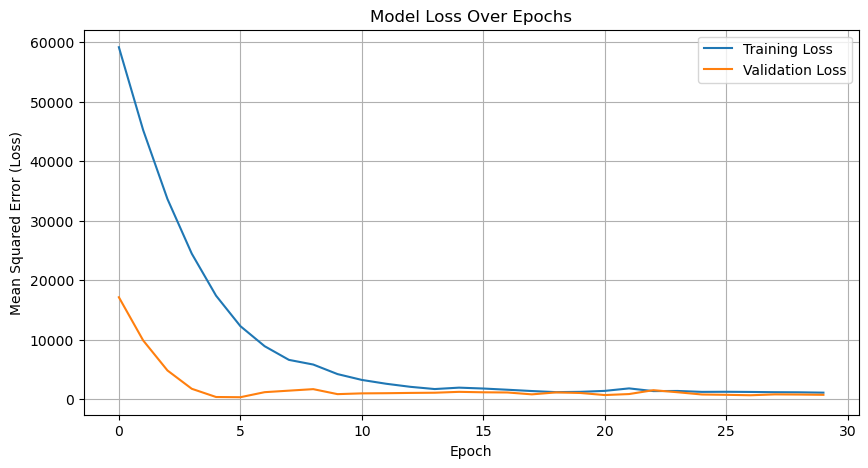

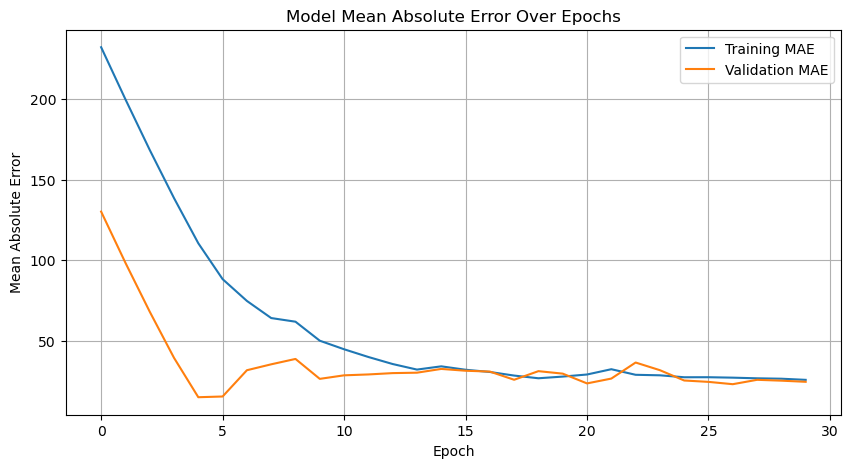

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
